# countland: rank reduction and dimensional reduction
**Samuel H. Church**

In [11]:
import countland

import numpy as np
import scanpy as sc

#!pip install git+https://github.com/shchurch/integer_matrix_approximation.git#subdirectory=IMA-python

import matplotlib
import matplotlib.pyplot as plt
matplotlib.pyplot.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import seaborn as sns

np.random.seed(84095)

This vignette demonstrates several methods for approximating a lower rank version of the count matrix, and for visualizing the count matrix in a reduced dimensional space.

Here we implement the `countland` clustering workflow on the Gold Standard dataset from [Freytag _et al_ (2018)](10.12688/f1000research.15809.2).

In [2]:
adata = sc.read_10x_mtx(
    "../data/Gold_Freytag2018",  # the directory with the `.mtx` file
    var_names='gene_symbols',    # use gene symbols for the variable names (variables-axis index)
    cache=True)                  # write a cache file for faster subsequent reading

C = countland.countland(adata)
print(C)
C.Dot()
C.Embed()
C.Cluster(n_clusters=3)


initializing countland object...
removing empty cells and genes...

        countland object
        Count matrix has 925 cells (rows)
         and 29212 genes (columns)
        The fraction of entries that are nonzero is 0.2905
        
Calculating dot products between rows...
    done.
performing spectral embedding on dot products...
    done.
performing spectral clustering on dot products...
    done.


## Spectral embedding

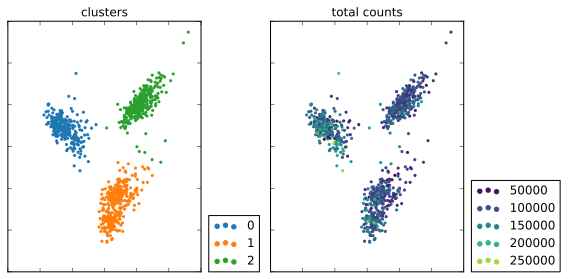

In [3]:
C.PlotEmbedding()

## Other methods of dimensional reduction

Rank reduction is a significant challenge with single-cell data, in large part because highly sparse data are highly difficult to reduce without discarding features entirely.

`countland` implements two forms of count-based rank reduction:


### Integer matrix approximation

Integer matrix factorization, described [here](https://mtchu.math.ncsu.edu/Research/Papers/bindec05f.pdf), is an approach to achieve a low-rank approximation of matrices that include only natural numbers. Like other matrix factorizations (e.g. singular-value decomposition), this method seeks to find lower-rank matrices that can be multiplied together to approximate a higher-rank matrix, here the count matrix. 

Integer matrix approximation generates three matrices, termed $\mathrm{U}$, $\mathrm{V}$, and $\Lambda$. When using integer matrix approximation on single-cell count data, matrix $\mathrm{U}$ has the dimensions $m$ cells by $k$ features, with $k$ provided as the target rank, $\mathrm{V}$ has the dimensions $k$ features by $n$ genes, and $\Lambda$ is a diagonal matrix of $k$ scaling factors.

Because of the discrete nature of count data, this factorization cannot be accomplished conventionally, but [approximations for this factorization](https://github.com/kperros/SUSTain) have been proposed for other types of count-based data. Here we implement the algorithm for integer matrix approximation in python and R, and apply it to the approximation of single-cell count data. The bounds of the integer values in each matrix can be changed to accomodate the data in question.

With IMA, we subsample cells because we don't want heterogeneity in sequencing depth to impact the factorization. We have also subsampled genes to a maximum expression value, here set at the number of cells times 10. This prevents the factorization from reflecting only a few highly expressed genes.

We can first identify a reasonable target rank by visualizing how many dimensions are required to best approximate the count matrix. 

subsampling 1592 genes to a max total counts of 9250
subsampling all cells to a standard sequencing depth of 14658
approximating count matrix using up to 20 features...
    done.


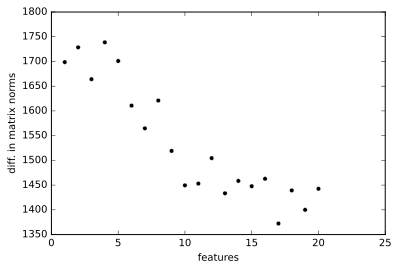

In [4]:
C.Subsample(gene_counts=C.counts.shape[0]*10,cell_counts="min")
    
max_features = 20 # compare results up to 20 features
u_bounds = [5,10] # with upper bounds of 5 for matrix U and 10 for matrix V

C.PlotIMAElbow(max_features = 20, u_bounds = [5,10])

Based on the elbow plot above, the approximation does not appear to improve by adding features beyond ~15.

In [5]:
C.IMA(features = 15, u_bounds = [5,10])

approximating count matrix...
    done.


We can visualize cells by embedding counts (matrix $\mathrm{C}$) in this reduced space. This is calculated with matrix multiplication $\mathrm{C(V}\Lambda)$. Components in this space are unordered, so it can be helpful to view cells embedded in several combinations of components.

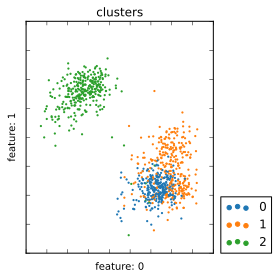

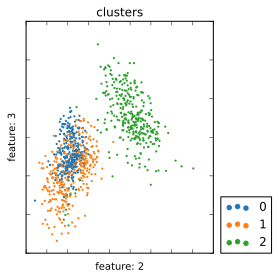

In [6]:
C.PlotIMA(x = 0, y = 1) # visualize cells using the features 0 and 1
C.PlotIMA(x = 2, y = 3) # visualize cells using the features 0 and 1

### Shared counts reduction 

Another method for reducing the dimensions is to collapse groups of genes with similar patterns of counts across cells. Here we can accomplish this by calculating the number of shared counts between all pairs of genes, identifying clusters of genes with similar counts, and then summing counts within clusters.

**Note: this can be very slow on large datasets**

Because calculating pairwise shared count values is memory intensive, this is performed using a random sample of cells, `n_cells` (default=`100`). It may be also be necessary to subset to a group of genes, say a sample of 10,000. 

Here we subsample cells to a standard sequencing depth because we want shared count values to reflect biological variation and not heterogeneity in depth. We haven't subsampled genes to a maximum expression, however, and the consequence of this is that highly expressed genes will have a large impact on the values of the summed meta-genes. This is helpful for separating cell populations in the visualization, but may result in some genes haven't an outsized impact. Choosing the correct subsampling procedure, if any, will depend on research objectives.

In [7]:
C.SubsetGenes(np.random.choice(range(C.counts.shape[1]),10000))
C.Subsample(cell_counts="min")
C.SharedCounts(n_clusters=7)

removing empty cells and genes...
Number of genes: 10000
Number of cells: 925
subsampling all cells to a standard sequencing depth of 13810
clustering genes based on shared counts...
    done.


Because the components of this dimensional reduction are groups of genes, it can be helpful to view several combinations to assess which capture a substantial amount of cell-cell variation.

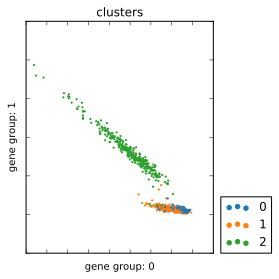

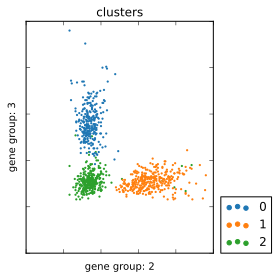

In [8]:
C.PlotSharedCounts(x = 0, y = 1)
C.PlotSharedCounts(x = 2, y = 3)

## Other visualization methods

### GLM-PCA

An alternative approach for comparing cells using untransformed counts is generalized linear model based PCA, or GLM-PCA. This has been described for scRNA-seq data [here](https://doi.org/10.1186/s13059-019-1861-6) and implemented [here](https://github.com/willtownes/glmpca-py).

**Note: this can also take some time.**

In [9]:
#!pip install git+https://github.com/willtownes/glmpca-py.git@master
from glmpca import glmpca

res = glmpca.glmpca(C.counts.T,2,fam="poi") # embed in 2 dimensions and use a Poisson model

[Text(0.5, 1.0, 'GLM-PCA: dot product clusters')]

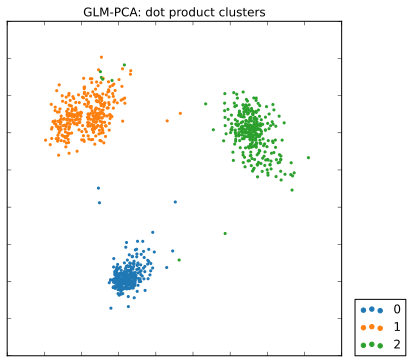

In [12]:
plt.figure(figsize = (6,6))

g = sns.scatterplot(x = res['factors'][:,0], # embeddings are stored in res['factors']
                y = res['factors'][:,1],
                hue = C.cluster_labels,
                palette="tab10",
                s =10,
                linewidth=0)
g.legend(loc=(1.04,0))
g.xaxis.set_ticklabels([])
g.yaxis.set_ticklabels([])
g.set(title="GLM-PCA: dot product clusters")